<a href="https://colab.research.google.com/github/Lucs1590/strava-analysis/blob/main/strava_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strava Analysis
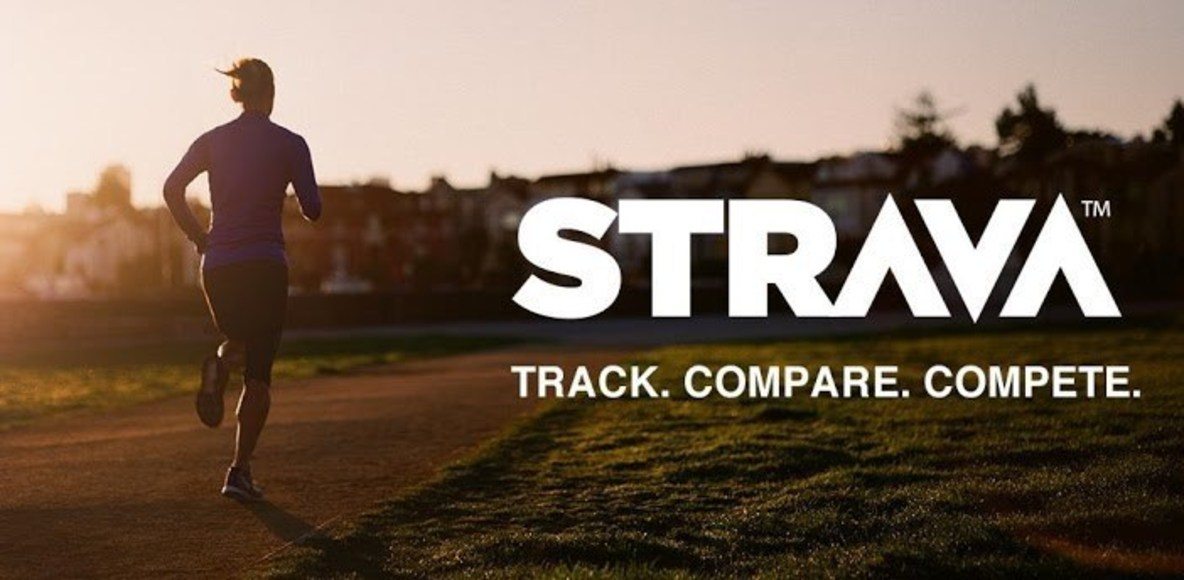
This notebook aims to make a data exploration searching by a pattern on user data and, after, try to predict the pace based on a distance and elevation.


## Imports

In [1]:
# general
import subprocess

# df and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# machine learning and math
import math
from sklearn.feature_selection import mutual_info_classif

## Getting data and first contact

In [2]:
pd.set_option('display.max_columns', None)
%matplotlib widget
%matplotlib inline

In [3]:
subprocess.call('python3 get_activities.py', shell=True)

Getting data from Strava
Getting data from page 1
Saving data/strava_activities_page_1.csv
Getting data from page 2
Saving data/strava_activities_page_2.csv
Getting data from page 3
Merging files
Saving result/strava_all_activities.csv
Done Successfully


0

In [4]:
df = pd.read_csv('result/strava_all_activities.csv')

In [5]:
df.head()

,Unnamed: 0,Unnamed: 0.1,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,id,start_date,start_date_local,timezone,utc_offset,location_city,location_state,location_country,achievement_count,kudos_count,comment_count,athlete_count,photo_count,trainer,commute,manual,private,visibility,flagged,gear_id,start_latlng,end_latlng,average_speed,max_speed,average_cadence,has_heartrate,average_heartrate,max_heartrate,heartrate_opt_out,display_hide_heartrate_option,elev_high,elev_low,upload_id,upload_id_str,external_id,from_accepted_tag,pr_count,total_photo_count,has_kudoed,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,average_watts,kilojoules,device_watts
0,0,0,2,Corrida ao entardecer,5043.1,1657,1657,25.8,Run,Run,NaN,7820148000,2022-09-16T21:24:44Z,2022-09-16T18:24:44Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,0,4,0,1,0,False,False,False,False,everyone,False,g7550415,"[-22.103806, -50.178505]","[-22.103674, -50.178593]",3.044,4.304,79.4,True,162.5,178.0,False,True,597.1,587.8,8.354538e+09,8.354538e+09,shealth9ed4cd9b-f960-4694-ad89-cef1d0c05c60.tcx,False,0,0,False,47005114,1,a7820148000,xc|eCtngqHf@yA`@q@pAcCx@cBf@{@lBmEf@}@z@mB`@o@...,2,NaN,NaN,NaN
1,1,1,2,Corrida ao entardecer,5034.8,1476,1479,30.1,Run,Run,NaN,7799159860,2022-09-12T21:12:20Z,2022-09-12T18:12:20Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,0,5,0,1,0,False,False,False,False,everyone,False,g7550415,"[-22.103722, -50.178715]","[-22.104866, -50.17659]",3.411,5.148,84.4,True,174.7,201.0,False,True,609.3,590.9,8.331015e+09,8.331015e+09,shealth9af8623a-cd7d-4950-8931-fbbdc6273c1f.tcx,False,0,0,False,47005114,1,a7799159860,hc|eC~ogqHK^MRUf@g@dBg@fCI~@[zFG~@Q|AM`BMnCEV?...,2,NaN,NaN,NaN
2,2,2,2,Corrida matinal,4059.1,1082,1113,52.6,Run,Run,NaN,7797415855,2022-09-11T11:00:49Z,2022-09-11T08:00:49Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,2,6,0,36,0,False,False,False,False,everyone,False,g7550415,"[-22.226671, -49.904984]","[-22.226599, -49.90492]",3.751,6.127,88.2,True,180.8,189.0,False,True,665.5,642.2,8.329083e+09,8.329083e+09,shealth74ec37c0-017b-4cfe-8985-193f5bac5154.tcx,False,0,0,False,47005114,1,a7797415855,vctfCdaroHF@Xn@TLHJP\^hA^pA`ArCDXT`CNlDEj@Fd@B...,2,NaN,NaN,NaN
3,3,3,2,Corrida matinal,5068.5,1789,1792,72.8,Run,Run,NaN,7722956337,2022-08-27T13:07:23Z,2022-08-27T10:07:23Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,0,4,0,2,0,False,False,False,False,everyone,False,g7550415,"[-22.741724, -47.594498]","[-22.767317, -47.58796]",2.833,5.246,80.3,True,174.1,185.0,False,True,631.0,588.5,8.244966e+09,8.244966e+09,shealthe81d2774-cec9-430f-8195-969fe6ae6cf5.tcx,False,0,0,False,47005114,1,a7722956337,xvxiCrxnaHEoADs@Ce@BsAUuAOo@U_CIQ?]Qe@g@o@?U@E...,2,NaN,NaN,NaN
4,4,4,2,Corrida ao entardecer,5040.5,1467,1467,21.1,Run,Run,NaN,7683587125,2022-08-22T21:15:53Z,2022-08-22T18:15:53Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,2,8,0,1,0,False,False,False,False,everyone,False,g7550415,"[-22.10379, -50.17853]","[-22.105629, -50.17524]",3.436,4.738,86.3,True,178.6,206.0,False,True,604.2,593.6,8.200458e+09,8.200458e+09,shealthb8915e5c-d94b-4839-a2ca-17c0427d799a.tcx,False,0,0,False,47005114,1,a7683587125,tc|eCxngqHbAeBb@cAXi@t@gBp@qAn@}AZk@\y@\m@dA{B...,2,NaN,NaN,NaN


In [6]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'resource_state', 'name', 'distance',
       'moving_time', 'elapsed_time', 'total_elevation_gain', 'type',
       'sport_type', 'workout_type', 'id', 'start_date', 'start_date_local',
       'timezone', 'utc_offset', 'location_city', 'location_state',
       'location_country', 'achievement_count', 'kudos_count', 'comment_count',
       'athlete_count', 'photo_count', 'trainer', 'commute', 'manual',
       'private', 'visibility', 'flagged', 'gear_id', 'start_latlng',
       'end_latlng', 'average_speed', 'max_speed', 'average_cadence',
       'has_heartrate', 'average_heartrate', 'max_heartrate',
       'heartrate_opt_out', 'display_hide_heartrate_option', 'elev_high',
       'elev_low', 'upload_id', 'upload_id_str', 'external_id',
       'from_accepted_tag', 'pr_count', 'total_photo_count', 'has_kudoed',
       'athlete.id', 'athlete.resource_state', 'map.id',
       'map.summary_polyline', 'map.resource_state', 'average_watts',
       'kilojoule

In [7]:
df.shape

(257, 58)

In [8]:
df.isnull().sum().sum()

2181

In [9]:
null_df = [[col, df[col].isnull().sum()] for col in df.columns]
list(filter(lambda x: x[1]>0, null_df))

[['workout_type', 122],
 ['location_city', 257],
 ['location_state', 257],
 ['location_country', 3],
 ['gear_id', 86],
 ['average_cadence', 97],
 ['average_heartrate', 166],
 ['max_heartrate', 166],
 ['elev_high', 46],
 ['elev_low', 46],
 ['upload_id', 42],
 ['upload_id_str', 42],
 ['external_id', 90],
 ['map.summary_polyline', 49],
 ['average_watts', 238],
 ['kilojoules', 238],
 ['device_watts', 236]]

## Data manipulation

In [10]:
raw_df = df

In [11]:
selected_columns = ['id','name', 'distance', 'moving_time', 'total_elevation_gain', 'type',
                    'start_date_local', 'athlete_count','average_speed', 'max_speed',
                    'average_cadence', 'average_heartrate','elev_high', 'elev_low', 'pr_count',
                    'average_watts', 'kilojoules', 'device_watts', 'map.summary_polyline']

In [12]:
df = df[selected_columns]
df.head()

,id,name,distance,moving_time,total_elevation_gain,type,start_date_local,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,elev_high,elev_low,pr_count,average_watts,kilojoules,device_watts,map.summary_polyline
0,7820148000,Corrida ao entardecer,5043.1,1657,25.8,Run,2022-09-16T18:24:44Z,1,3.044,4.304,79.4,162.5,597.1,587.8,0,NaN,NaN,NaN,xc|eCtngqHf@yA`@q@pAcCx@cBf@{@lBmEf@}@z@mB`@o@...
1,7799159860,Corrida ao entardecer,5034.8,1476,30.1,Run,2022-09-12T18:12:20Z,1,3.411,5.148,84.4,174.7,609.3,590.9,0,NaN,NaN,NaN,hc|eC~ogqHK^MRUf@g@dBg@fCI~@[zFG~@Q|AM`BMnCEV?...
2,7797415855,Corrida matinal,4059.1,1082,52.6,Run,2022-09-11T08:00:49Z,36,3.751,6.127,88.2,180.8,665.5,642.2,0,NaN,NaN,NaN,vctfCdaroHF@Xn@TLHJP\^hA^pA`ArCDXT`CNlDEj@Fd@B...
3,7722956337,Corrida matinal,5068.5,1789,72.8,Run,2022-08-27T10:07:23Z,2,2.833,5.246,80.3,174.1,631.0,588.5,0,NaN,NaN,NaN,xvxiCrxnaHEoADs@Ce@BsAUuAOo@U_CIQ?]Qe@g@o@?U@E...
4,7683587125,Corrida ao entardecer,5040.5,1467,21.1,Run,2022-08-22T18:15:53Z,1,3.436,4.738,86.3,178.6,604.2,593.6,0,NaN,NaN,NaN,tc|eCxngqHbAeBb@cAXi@t@gBp@qAn@}AZk@\y@\m@dA{B...


In [13]:
df['start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_4536/4095640816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')


In [14]:
df = df.sort_values(by='start_date_local')

In [15]:
df['start_time'] = df['start_date_local'].dt.time
df['start_date'] = df['start_date_local'].dt.date

In [16]:
df = df.drop('start_date_local', 1)
df.head()

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_4536/2372681409.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('start_date_local', 1)


,id,name,distance,moving_time,total_elevation_gain,type,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,elev_high,elev_low,pr_count,average_watts,kilojoules,device_watts,map.summary_polyline,start_time,start_date
256,2753119647,Evening Ride,1585.6,345,10.3,Ride,1,4.596,8.9,NaN,NaN,606.2,596.4,0,NaN,NaN,False,``ueCpo_rHEBd@jAt@z@bBbCrBbDTn@?HDHR^^z@h@~ApA...,20:09:18,2019-09-30
255,2753195842,Evening Run,1556.1,477,26.0,Run,1,3.262,3.6,NaN,NaN,602.6,589.4,0,NaN,NaN,NaN,b~teC|s`rHhAxD`BrD@HRr@Vv@R`@gEaMEJDB?HLd@Vv@b...,20:33:06,2019-09-30
254,2753233770,Night Ride,225.4,61,0.0,Ride,1,3.695,7.1,NaN,NaN,607.3,599.1,0,NaN,NaN,False,bpueCto`rHP@BGf@QBG?MKs@[iAuAuD,21:15:01,2019-09-30
253,2755746533,Evening Ride,203.7,62,0.0,Ride,1,3.285,7.7,NaN,NaN,599.0,596.8,0,28.3,1.8,False,NaN,20:08:30,2019-10-01
252,2755853084,Night Ride,192.9,61,0.0,Ride,1,3.162,6.2,NaN,NaN,607.1,599.2,0,69.3,4.2,False,loueCzo`rHNDH?f@WDE@GG}@S}@{@eC,21:02:29,2019-10-01


In [17]:
df = df.drop(df[df.average_speed > 30].index)
df = df.reset_index(drop=True)

In [18]:
df['moving_time_minutes'] = round(df['moving_time']/60, 2)
df['distance_km'] = round(df['distance'] / 1000, 2)
df['pace'] = df['moving_time_minutes'] / df['distance_km']
df['avg_speed_kmh'] = round(60/df['pace'], 2)
df['max_speed_kmh'] = round(df['max_speed']*3.6, 2)
df['elev'] = df['elev_high'] - df['elev_low']

df['pace_sub_5'] = np.where(df['pace']<=5, True, False)
df

,id,name,distance,moving_time,total_elevation_gain,type,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,elev_high,elev_low,pr_count,average_watts,kilojoules,device_watts,map.summary_polyline,start_time,start_date,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,pace_sub_5
0,2753119647,Evening Ride,1585.6,345,10.3,Ride,1,4.596,8.900,NaN,NaN,606.2,596.4,0,NaN,NaN,False,``ueCpo_rHEBd@jAt@z@bBbCrBbDTn@?HDHR^^z@h@~ApA...,20:09:18,2019-09-30,5.75,1.59,3.616352,16.59,32.04,9.8,True
1,2753195842,Evening Run,1556.1,477,26.0,Run,1,3.262,3.600,NaN,NaN,602.6,589.4,0,NaN,NaN,NaN,b~teC|s`rHhAxD`BrD@HRr@Vv@R`@gEaMEJDB?HLd@Vv@b...,20:33:06,2019-09-30,7.95,1.56,5.096154,11.77,12.96,13.2,False
2,2753233770,Night Ride,225.4,61,0.0,Ride,1,3.695,7.100,NaN,NaN,607.3,599.1,0,NaN,NaN,False,bpueCto`rHP@BGf@QBG?MKs@[iAuAuD,21:15:01,2019-09-30,1.02,0.23,4.434783,13.53,25.56,8.2,True
3,2755746533,Evening Ride,203.7,62,0.0,Ride,1,3.285,7.700,NaN,NaN,599.0,596.8,0,28.3,1.8,False,NaN,20:08:30,2019-10-01,1.03,0.20,5.150000,11.65,27.72,2.2,False
4,2755853084,Night Ride,192.9,61,0.0,Ride,1,3.162,6.200,NaN,NaN,607.1,599.2,0,69.3,4.2,False,loueCzo`rHNDH?f@WDE@GG}@S}@{@eC,21:02:29,2019-10-01,1.02,0.19,5.368421,11.18,22.32,7.9,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,7683587125,Corrida ao entardecer,5040.5,1467,21.1,Run,1,3.436,4.738,86.3,178.6,604.2,593.6,0,NaN,NaN,NaN,tc|eCxngqHbAeBb@cAXi@t@gBp@qAn@}AZk@\y@\m@dA{B...,18:15:53,2022-08-22,24.45,5.04,4.851190,12.37,17.06,10.6,True
253,7722956337,Corrida matinal,5068.5,1789,72.8,Run,2,2.833,5.246,80.3,174.1,631.0,588.5,0,NaN,NaN,NaN,xvxiCrxnaHEoADs@Ce@BsAUuAOo@U_CIQ?]Qe@g@o@?U@E...,10:07:23,2022-08-27,29.82,5.07,5.881657,10.20,18.89,42.5,False
254,7797415855,Corrida matinal,4059.1,1082,52.6,Run,36,3.751,6.127,88.2,180.8,665.5,642.2,0,NaN,NaN,NaN,vctfCdaroHF@Xn@TLHJP\^hA^pA`ArCDXT`CNlDEj@Fd@B...,08:00:49,2022-09-11,18.03,4.06,4.440887,13.51,22.06,23.3,True
255,7799159860,Corrida ao entardecer,5034.8,1476,30.1,Run,1,3.411,5.148,84.4,174.7,609.3,590.9,0,NaN,NaN,NaN,hc|eC~ogqHK^MRUf@g@dBg@fCI~@[zFG~@Q|AM`BMnCEV?...,18:12:20,2022-09-12,24.60,5.03,4.890656,12.27,18.53,18.4,True


## Visualization

Text(0.5, 1.0, 'Exercices')

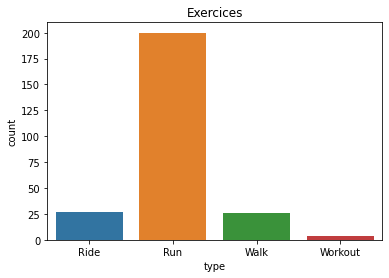

In [19]:
fig = sns.countplot(x='type', data=df).set_title('Exercices')
fig

In [20]:
df['year']= df['start_date'].map(lambda x: x.year)

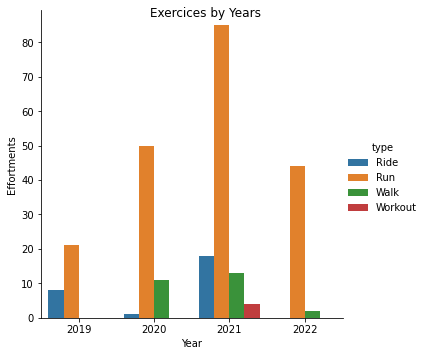

In [21]:
fig = sns.catplot(x='year', hue='type', data=df, kind='count')
fig.fig.suptitle('Exercices by Years')
fig.set_xlabels('Year')
fig.set_ylabels('Effortments')
fig

## Running Analysis

In [22]:
runs = df.loc[df['type'] == 'Run']
runs

,id,name,distance,moving_time,total_elevation_gain,type,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,elev_high,elev_low,pr_count,average_watts,kilojoules,device_watts,map.summary_polyline,start_time,start_date,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,pace_sub_5,year
1,2753195842,Evening Run,1556.1,477,26.0,Run,1,3.262,3.600,NaN,NaN,602.6,589.4,0,NaN,NaN,NaN,b~teC|s`rHhAxD`BrD@HRr@Vv@R`@gEaMEJDB?HLd@Vv@b...,20:33:06,2019-09-30,7.95,1.56,5.096154,11.77,12.96,13.2,False,2019
6,2781031587,Night Run,102.0,61,0.0,Run,1,1.672,1.900,NaN,NaN,594.4,589.9,0,NaN,NaN,NaN,reueClcarHa@y@y@qB,21:40:58,2019-10-09,1.02,0.10,10.200000,5.88,6.84,4.5,False,2019
8,2781127867,Evening Ride,2586.9,2756,54.0,Run,1,0.939,3.800,NaN,NaN,597.5,588.2,0,NaN,NaN,NaN,z~teC`t`rHG?@DJXDd@DPVr@T^dAjDgA_D[u@_@wAKo@Ei...,19:06:54,2019-10-11,45.93,2.59,17.733591,3.38,13.68,9.3,False,2019
10,2789528029,Evening Run,2219.2,1068,39.3,Run,2,2.078,3.700,NaN,NaN,597.5,588.8,3,NaN,NaN,NaN,r~teCvu`rHBTVd@FVbB|DIIYw@AM_@{@iBmBHMFEJS?q@C...,19:50:11,2019-10-14,17.80,2.22,8.018018,7.48,13.32,8.7,False,2019
11,2828174770,Morning Run,4505.2,2092,41.4,Run,2,2.154,3.700,NaN,NaN,618.5,595.9,4,NaN,NaN,NaN,za}eCh{jqHCKEBAHKXo@jAk@nAQX_@~@c@x@qA|C[l@Y^U...,07:15:57,2019-10-30,34.87,4.51,7.731707,7.76,13.32,22.6,False,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,7683587125,Corrida ao entardecer,5040.5,1467,21.1,Run,1,3.436,4.738,86.3,178.6,604.2,593.6,0,NaN,NaN,NaN,tc|eCxngqHbAeBb@cAXi@t@gBp@qAn@}AZk@\y@\m@dA{B...,18:15:53,2022-08-22,24.45,5.04,4.851190,12.37,17.06,10.6,True,2022
253,7722956337,Corrida matinal,5068.5,1789,72.8,Run,2,2.833,5.246,80.3,174.1,631.0,588.5,0,NaN,NaN,NaN,xvxiCrxnaHEoADs@Ce@BsAUuAOo@U_CIQ?]Qe@g@o@?U@E...,10:07:23,2022-08-27,29.82,5.07,5.881657,10.20,18.89,42.5,False,2022
254,7797415855,Corrida matinal,4059.1,1082,52.6,Run,36,3.751,6.127,88.2,180.8,665.5,642.2,0,NaN,NaN,NaN,vctfCdaroHF@Xn@TLHJP\^hA^pA`ArCDXT`CNlDEj@Fd@B...,08:00:49,2022-09-11,18.03,4.06,4.440887,13.51,22.06,23.3,True,2022
255,7799159860,Corrida ao entardecer,5034.8,1476,30.1,Run,1,3.411,5.148,84.4,174.7,609.3,590.9,0,NaN,NaN,NaN,hc|eC~ogqHK^MRUf@g@dBg@fCI~@[zFG~@Q|AM`BMnCEV?...,18:12:20,2022-09-12,24.60,5.03,4.890656,12.27,18.53,18.4,True,2022


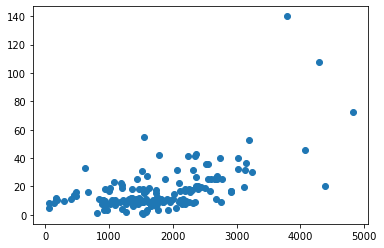

In [23]:
plt.scatter(runs['moving_time'],runs['elev'])
plt.show()

Text(0.5, 1.0, 'All Time vs Elevation')

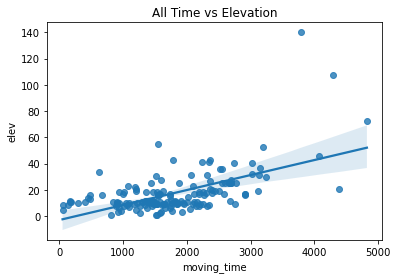

In [24]:
sns.regplot(x='moving_time', y = 'elev', data=runs).set_title("All Time vs Elevation")

Text(0.5, 1.0, 'Average Speed vs Distance')

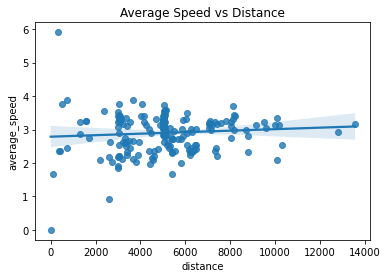

In [25]:
sns.regplot(x='distance', y = 'average_speed', data=runs).set_title("Average Speed vs Distance")

Text(0.5, 1.0, 'Max Speed vs Distance')

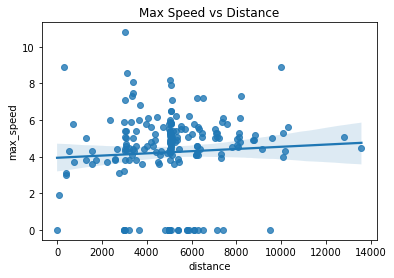

In [26]:
sns.regplot(x='distance', y = 'max_speed', data=runs).set_title("Max Speed vs Distance")

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_4536/3097083979.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


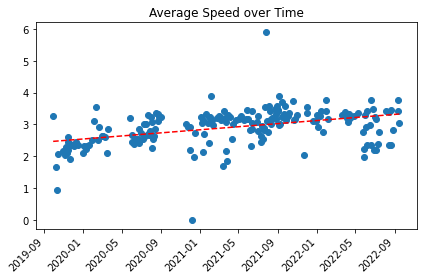

In [27]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(runs.start_date)
y = np.asarray(runs.average_speed)

ax1.plot_date(x, y)
ax1.set_title('Average Speed over Time')

#add trend line
x2 = mdates.date2num(x)

z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')

fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

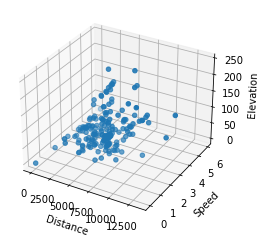

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = runs['distance']
y = runs['average_speed']
z = runs['total_elevation_gain']

ax.set_xlabel("Distance")
ax.set_ylabel("Speed")
ax.set_zlabel("Elevation")

ax.scatter(x, y, z)

plt.show()

In [29]:
startdate = pd.to_datetime("2021-01-01").date()
recently_runs = runs.loc[runs['start_date'] > startdate]

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_4536/2438023629.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


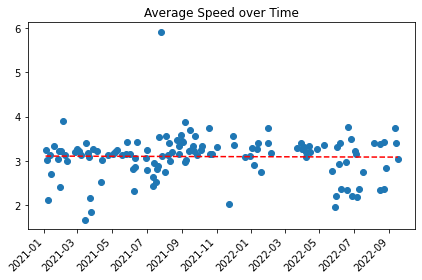

In [30]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(recently_runs.start_date)
y = np.asarray(recently_runs.average_speed)

ax1.plot_date(x, y)
ax1.set_title('Average Speed over Time')

#add trend line
x1 = mdates.date2num(x)

z=np.polyfit(x1,y,1)
p=np.poly1d(z)
plt.plot(x,p(x1),'r--')

fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_4536/2503613642.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


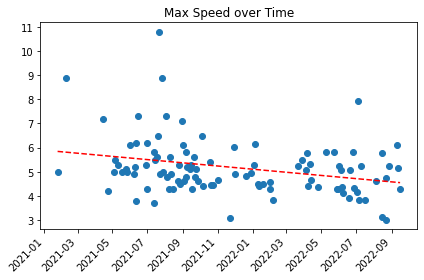

In [31]:
#max speed over time
fig = plt.figure()
ax2 = fig.add_subplot(111)

recently_runs = recently_runs.drop(recently_runs[recently_runs.max_speed == 0].index)


x = np.asarray(recently_runs.start_date)
y = np.asarray(recently_runs.max_speed)

ax2.plot_date(x, y)
ax2.set_title('Max Speed over Time')

#add trend line
x2 = mdates.date2num(x)

z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')

fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()